# Project

Name: Raashna Chand

Student ID: 300607575

This project develops a machine learning model to predict the probabilities of whether people received the H1N1 vaccine based on the background, opinions, and health behaviors that respondents disclosed.

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

np.random.seed = 10

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

We will first browse the test set to see if there are any NaN and null values.

In [3]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 2659 non-null   float64
 1   h1n1_knowledge               2659 non-null   float64
 2   behavioral_antiviral_meds    2659 non-null   float64
 3   behavioral_avoidance         2647 non-null   float64
 4   behavioral_face_mask         2668 non-null   float64
 5   behavioral_wash_hands        2669 non-null   float64
 6   behavioral_large_gatherings  2667 non-null   float64
 7   behavioral_outside_home      2661 non-null   float64
 8   behavioral_touch_face        2658 non-null   float64
 9   doctor_recc_h1n1             2470 non-null   float64
 10  doctor_recc_seasonal         2470 non-null   float64
 11  chronic_med_condition        2578 non-null   float64
 12  child_under_6_months         2598 non-null   float64
 13  health_worker     

Almost all columns have null and NaN entries. We will deal with them while encoding.

Separate predictors and labels:

In [4]:
X_train = train_set.drop("h1n1_vaccine", axis=1)
y_train = train_set["h1n1_vaccine"].copy()
X_test = test_set.drop("h1n1_vaccine", axis=1)
y_test = test_set["h1n1_vaccine"].copy()

We will gain some insights into the training set.

In [5]:
data = train_set.copy()

array([[<AxesSubplot:title={'center':'h1n1_concern'}>,
        <AxesSubplot:title={'center':'h1n1_knowledge'}>,
        <AxesSubplot:title={'center':'behavioral_antiviral_meds'}>,
        <AxesSubplot:title={'center':'behavioral_avoidance'}>,
        <AxesSubplot:title={'center':'behavioral_face_mask'}>],
       [<AxesSubplot:title={'center':'behavioral_wash_hands'}>,
        <AxesSubplot:title={'center':'behavioral_large_gatherings'}>,
        <AxesSubplot:title={'center':'behavioral_outside_home'}>,
        <AxesSubplot:title={'center':'behavioral_touch_face'}>,
        <AxesSubplot:title={'center':'doctor_recc_h1n1'}>],
       [<AxesSubplot:title={'center':'doctor_recc_seasonal'}>,
        <AxesSubplot:title={'center':'chronic_med_condition'}>,
        <AxesSubplot:title={'center':'child_under_6_months'}>,
        <AxesSubplot:title={'center':'health_worker'}>,
        <AxesSubplot:title={'center':'health_insurance'}>],
       [<AxesSubplot:title={'center':'opinion_h1n1_vacc_effecti

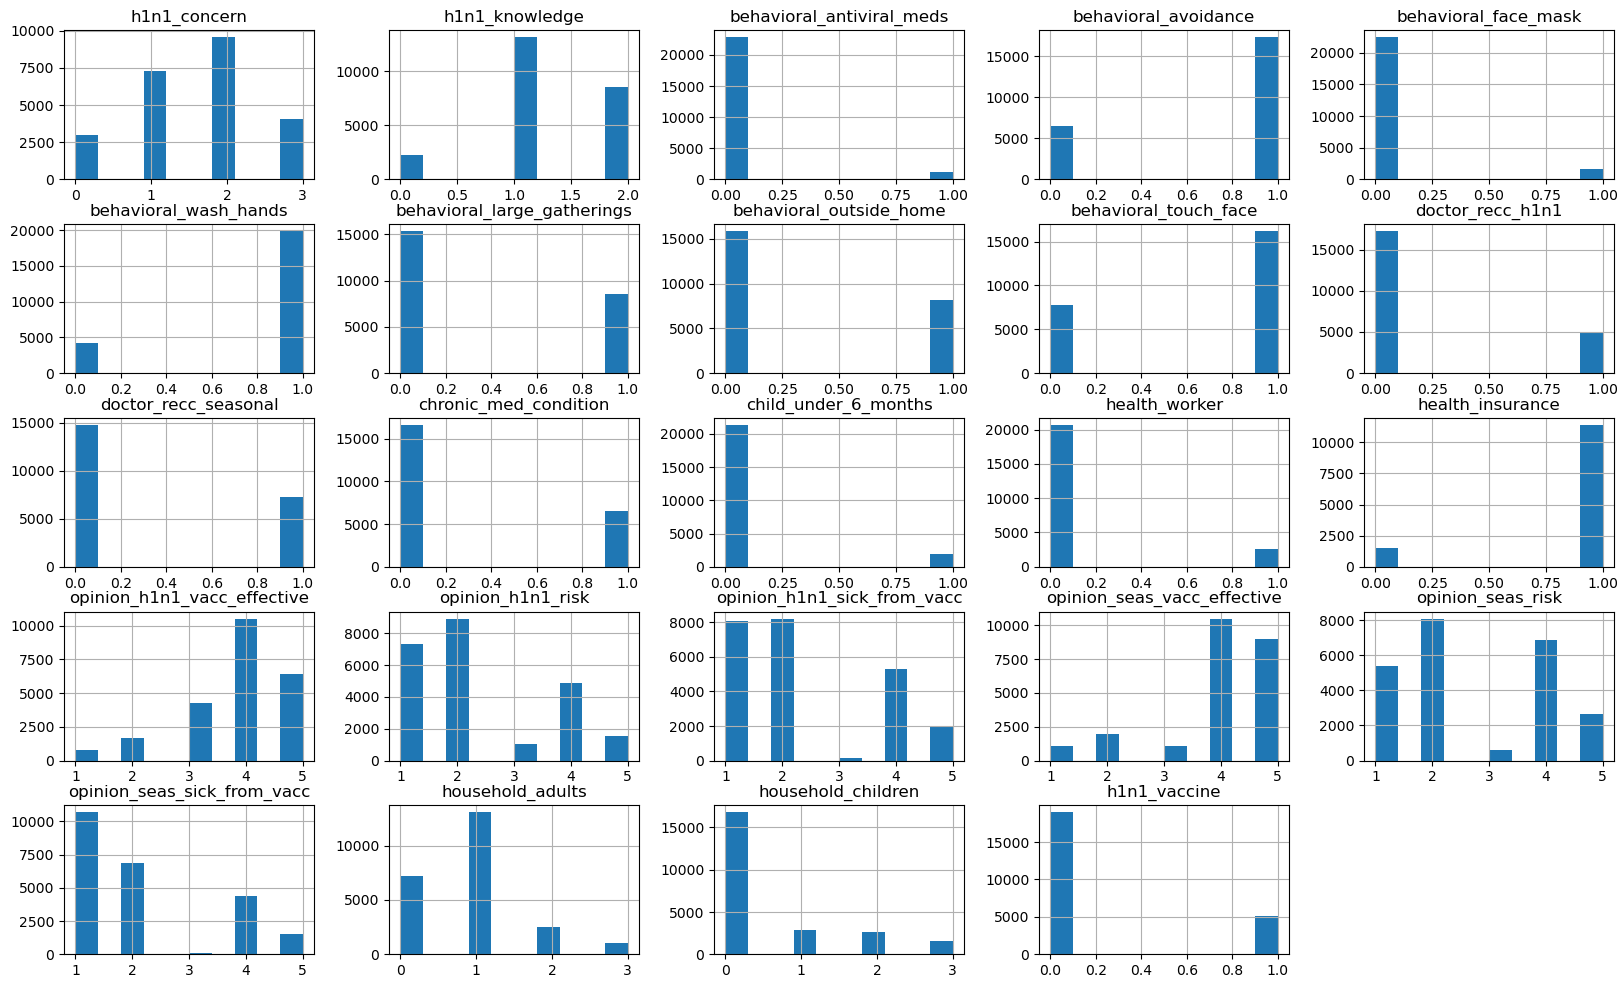

In [6]:
data.hist(figsize=(20,12))

Most people seem to have an opinion on the h1n1 and the seasonal flu vaccine, with very few people having no opinion/not knowing. Doctors also tend to not recommend either vaccine to the respondents. Most respondents do not have any children in their household. A lot of respondents live alone or with one other partner.

Implement transformer preprocessor to the numerical and nominal columns.

In [7]:
#Sort by numerical and nominal
numerical_columns = ['household_adults', 'household_children', 
                     'opinion_h1n1_vacc_effective', 'opinion_seas_vacc_effective', 
                    'opinion_h1n1_risk', 'opinion_seas_risk', 
                    'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'h1n1_concern', 
                    'h1n1_knowledge']
nominal_columns = ['age_group', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                   'behavioral_face_mask', 'behavioral_wash_hands', 
                   'behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_h1n1',
                  'chronic_med_condition', 'child_under_6_months',
                  'health_worker', 'health_insurance', 'education',
                  'race', 'sex', 'marital_status', 'rent_or_own',
                  'employment_status']

#Define estimators, transformers, and encoders. Handle unknowns by ignoring them
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                               ('scaler', StandardScaler())])
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])

We implement transformers for the ordinal column of `income_poverty`.

In [8]:
ordinal_columns= ['income_poverty']
order = [['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']]

#Def estimators, transformers, and encoders. Handle unknowns by ignoring them

ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OrdinalEncoder(categories=order,
                                                        handle_unknown='use_encoded_value',
                                                        unknown_value=-1,)),
                             ('scaler', StandardScaler())])

Now we implement the transformers.

In [9]:
#Apply these transformers to the columns
preprocessor = ColumnTransformer([('numerical_transformer', numerical_pipeline, numerical_columns),
                                  ('nominal_transformer', nominal_pipeline, nominal_columns),
                                 ('ordinal_transformer', ordinal_pipeline, ordinal_columns)])

In [10]:
#dummy classifier
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

Now we evaluate the models. First we will choose the Logistic Regression model.

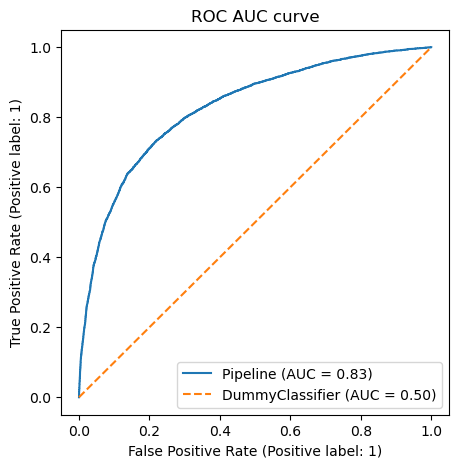

In [11]:
lr_model = Pipeline([('preprocessor', preprocessor), ('regressor', LogisticRegression())])

lr_model.fit(X_train, y_train);

y_train_predicted = lr_model.predict(X_train)

f = RocCurveDisplay.from_estimator(lr_model, X_train, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [12]:
roc_auc_score(y_train, lr_model.predict_proba(X_train)[:,1])

0.8277246824212607

In [13]:
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")
scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print(f"Balanced accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")

Accuracy score: 0.8347 +/- 0.0036
Balanced accuracy score: 0.6786 +/- 0.0084


Now we will try the Random Forest model.

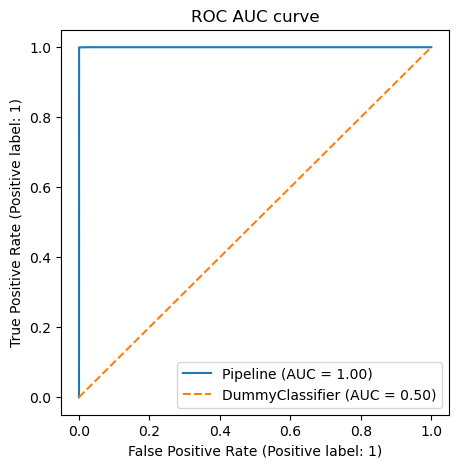

In [14]:
rf_model = Pipeline([('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(random_state=0))
                    ])
rf_model.fit(X_train, y_train);
y_train_predicted = rf_model.predict(X_train);

f = RocCurveDisplay.from_estimator(rf_model, X_train, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [15]:
rf_model_roc_auc = roc_auc_score(y_train, rf_model.predict_proba(X_train)[:,1])
rf_model_roc_auc

0.9999962189173712

In [16]:
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")
scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print(f"Balanced accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")

Accuracy score: 0.8369 +/- 0.0049
Balanced accuracy score: 0.6819 +/- 0.0090


A lot better and slightly more accurate.

Now we try the SVM model.

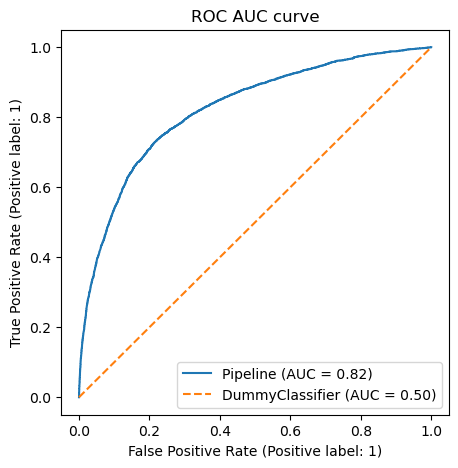

In [17]:
from sklearn.svm import SVC
svm_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', SVC(kernel='linear', probability=True, C=1.0, random_state=0))
                                ])
svm_classifier.fit(X_train, y_train)

f = RocCurveDisplay.from_estimator(svm_classifier, X_train, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [18]:
roc_auc_score(y_train, svm_classifier.predict_proba(X_train)[:,1])

0.8230312370194083

In [19]:
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(svm_classifier, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")
scores = cross_val_score(svm_classifier, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print(f"Balanced accuracy score: {scores.mean():.4f} +/- {scores.std():.4f}")

Accuracy score: 0.8293 +/- 0.0015
Balanced accuracy score: 0.6839 +/- 0.0044


It seems like the Random Forest model is the best, so we will use this on the test set, and it will be our model A.

I would like to see if the removal of the opinions columns from the dataset will make a difference to the AUC-ROC score. 

In [20]:
X_train_A = X_train.drop(['opinion_h1n1_vacc_effective','opinion_seas_vacc_effective', 
                    'opinion_h1n1_risk', 'opinion_seas_risk', 
                    'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc'], axis=1)
numerical_columns_2 = ['household_adults', 'household_children','h1n1_concern', 
                    'h1n1_knowledge']

numerical_pipeline_2 = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                               ('scaler', StandardScaler())])
preprocessor_2 = ColumnTransformer([('numerical_transformer', numerical_pipeline_2, numerical_columns_2),
                                  ('nominal_transformer', nominal_pipeline, nominal_columns),
                                 ('ordinal_transformer', ordinal_pipeline, ordinal_columns)])

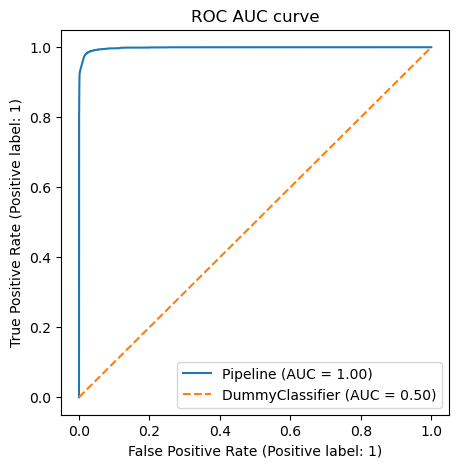

In [21]:
rf_model_A = Pipeline([('preprocessor', preprocessor_2),
                     ('classifier', RandomForestClassifier(random_state=0))
                    ])
rf_model_A.fit(X_train_A, y_train);
y_train_predicted = rf_model_A.predict(X_train_A);

f = RocCurveDisplay.from_estimator(rf_model_A, X_train_A, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train_A, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [22]:
roc_auc_score(y_train, rf_model_A.predict_proba(X_train_A)[:,1])

0.9982537682747307

This performs worse.

I will put these columns back and remove the education, marital status and housing situation columns.

In [23]:
X_train_A_2 = X_train.drop(['education', 'marital_status', 'rent_or_own'], axis=1)

nominal_columns_2 = ['age_group', 'behavioral_antiviral_meds', 'behavioral_avoidance', 
                   'behavioral_face_mask', 'behavioral_wash_hands', 
                   'behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_h1n1',
                  'chronic_med_condition', 'child_under_6_months',
                  'health_worker', 'health_insurance', 'race', 'sex',
                  'employment_status']
nominal_pipeline_2 = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_3 = ColumnTransformer([('numerical_transformer', numerical_pipeline, numerical_columns),
                                  ('nominal_transformer', nominal_pipeline_2, nominal_columns_2),
                                 ('ordinal_transformer', ordinal_pipeline, ordinal_columns)])

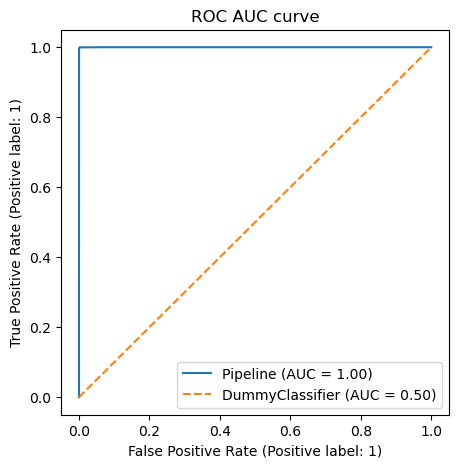

In [24]:
rf_model_A_2 = Pipeline([('preprocessor', preprocessor_3),
                     ('classifier', RandomForestClassifier(random_state=0))
                    ])
rf_model_A_2.fit(X_train_A_2, y_train);
y_train_predicted = rf_model_A_2.predict(X_train_A_2);

f = RocCurveDisplay.from_estimator(rf_model_A_2, X_train_A_2, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train_A_2, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [25]:
roc_auc_score(y_train, rf_model_A_2.predict_proba(X_train_A_2)[:,1])

0.9999879140394549

Recompare with our original model trained: `0.9999962189173712`. The above model performs slightly worse. So we will keep our original model trained.

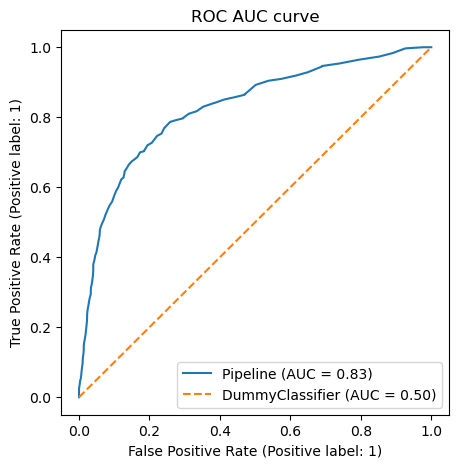

In [26]:
y_test_predicted = rf_model.predict(X_test)
f = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_test, y_test, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [27]:
roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])

0.8257770680035579

We will also report on the AUC-PR, the accuracy, the sensitivity, and the specificity.

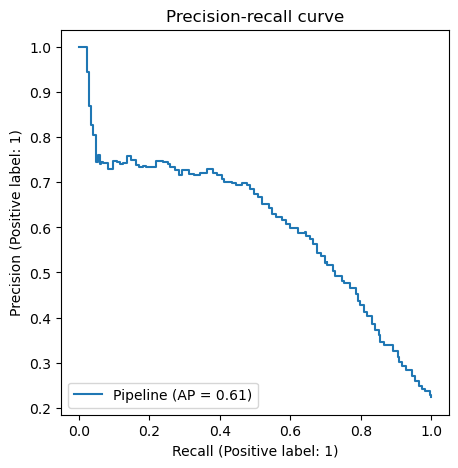

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

f = PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f.ax_.set_title("Precision-recall curve");

In [29]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=1)

0.6063589426505896

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
M = confusion_matrix(y_test, y_test_predicted)
tn, fp, fn, tp = M.ravel()
acc = (tp + tn) / (tn + tp + fn + fp)
sen = tp / (tp + fn)
spe = tn / (tn + fp)
print(f'Accuracy: {acc}\nSensitivity: {sen}\nSpecificity: {spe}')

Accuracy: 0.8307749906402097
Sensitivity: 0.412751677852349
Specificity: 0.9508433734939759


## Model B

To select the five-six features we use LASSO regression.

In [31]:
from sklearn.linear_model import Lasso
#LASSO regression required an alpha value of 0.019 to get 6 features.
lasso_pipe = Pipeline([('preprocessor', preprocessor),
                        ('lasso', Lasso(alpha=0.019, max_iter=50000))])
lasso_pipe.fit(X_train, y_train)
print("Number of features used: {}".format(np.sum(lasso_pipe['lasso'].coef_ != 0)))

Number of features used: 6


In [32]:
#Extracting the features that the LASSO regression used.
lasso_model = lasso_pipe['lasso']
coefficients = lasso_model.coef_
selected_feature_indices = [i for i, coef in enumerate(coefficients) if coef != 0]
selected_feature_names = X_train.columns[selected_feature_indices]
selected_feature_names

Index(['behavioral_antiviral_meds', 'behavioral_face_mask',
       'behavioral_wash_hands', 'doctor_recc_h1n1', 'household_adults',
       'household_children'],
      dtype='object')

In [33]:
X_train_B = X_train[['behavioral_antiviral_meds', 'behavioral_face_mask',
       'behavioral_wash_hands', 'doctor_recc_h1n1', 'household_adults',
       'household_children']].copy()

We will use a logistic regression model as our model B.

In [34]:
#Sort by numerical and nominal
numerical_columns_3 = ['household_adults', 'household_children']
nominal_columns_3 = ['behavioral_antiviral_meds', 'behavioral_face_mask', 
                     'behavioral_wash_hands', 'doctor_recc_h1n1',]

#Define estimators, transformers, and encoders. Handle unknowns by ignoring them
numerical_pipeline_3 = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                               ('scaler', StandardScaler())])
nominal_pipeline_3 = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_4 = ColumnTransformer([('numerical_transformer', numerical_pipeline_3, numerical_columns_3),
                                  ('nominal_transformer', nominal_pipeline_3, nominal_columns_3)])

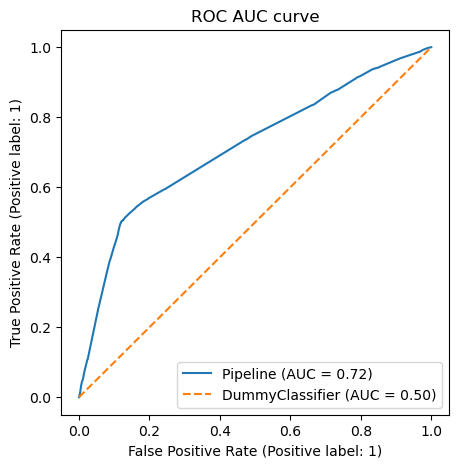

In [35]:
lr_model_B = Pipeline([('preprocessor', preprocessor_4), ('regressor', LogisticRegression())])

lr_model_B.fit(X_train_B, y_train);

y_train_predicted = lr_model_B.predict(X_train_B)

f = RocCurveDisplay.from_estimator(lr_model_B, X_train_B, y_train, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_train_B, y_train, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [36]:
roc_auc_score(y_train, lr_model_B.predict_proba(X_train)[:,1])

0.7151562640427228

Now we will use it on the test set.

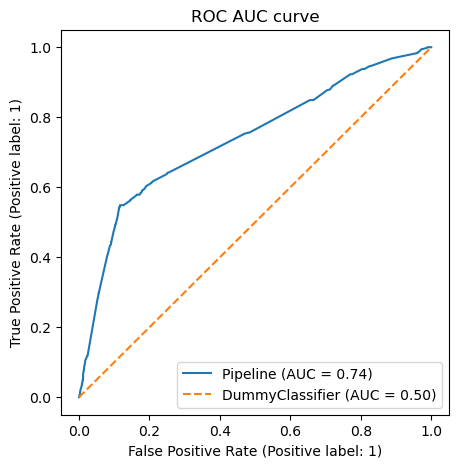

In [37]:
y_test_predicted = lr_model_B.predict(X_test)
f = RocCurveDisplay.from_estimator(lr_model_B, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(dummy_classifier, X_test, y_test, pos_label=1,
color="tab:orange", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

In [38]:
roc_auc_score(y_test, lr_model_B.predict_proba(X_test)[:,1])

0.7372018274440042

We will also report on the AUC-PR, the accuracy, the sensitivity, and the specificity.

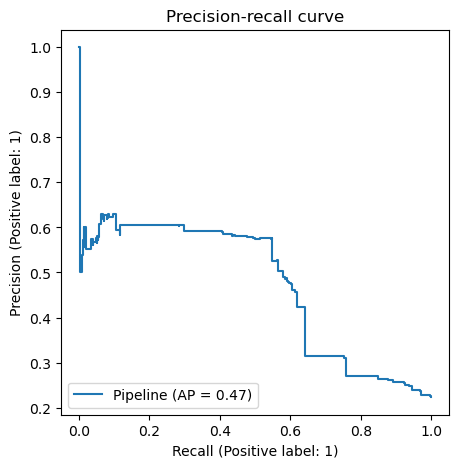

In [39]:
f = PrecisionRecallDisplay.from_estimator(lr_model_B, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f.ax_.set_title("Precision-recall curve");

In [40]:
average_precision_score(y_test, lr_model_B.predict_proba(X_test)[:,1], pos_label=1)

0.46912406187921696

In [41]:
M = confusion_matrix(y_test, y_test_predicted)
tn, fp, fn, tp = M.ravel()
acc = (tp + tn) / (tn + tp + fn + fp)
sen = tp / (tp + fn)
spe = tn / (tn + fp)
print(f'Accuracy: {acc}\nSensitivity: {sen}\nSpecificity: {spe}')

Accuracy: 0.8064395357543991
Sensitivity: 0.4748322147651007
Specificity: 0.9016867469879518


We will plot the ROC and PR curves of model A and B on the same plot.

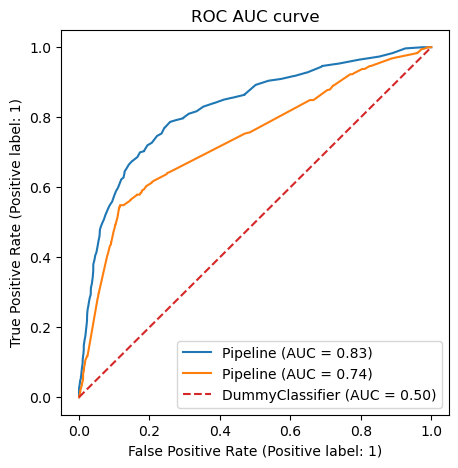

In [42]:
f = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = RocCurveDisplay.from_estimator(lr_model_B, X_test, y_test, pos_label=1,
ax=f.ax_)
f = RocCurveDisplay.from_estimator(dummy_classifier, X_test, y_test, pos_label=1,
color="tab:red", linestyle="--", ax=f.ax_)
f.ax_.set_title("ROC AUC curve");

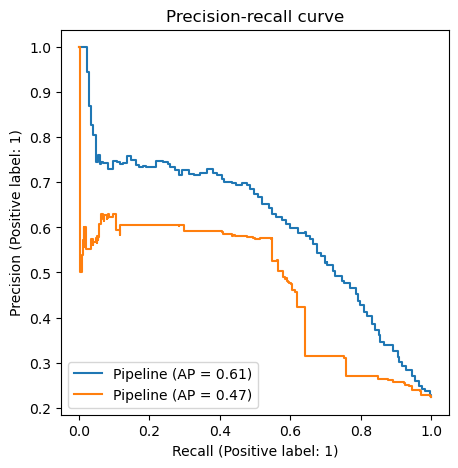

In [43]:
f = PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, pos_label=1,
ax=pl.figure(figsize=(5,5)).gca())
f = PrecisionRecallDisplay.from_estimator(lr_model_B, X_test, y_test, pos_label=1,
ax=f.ax_)
f.ax_.set_title("Precision-recall curve");

That concludes the project.

# Discussion
Some difficulties I had were:
* attempting to optimize model A to a point that was even better than the current model. My attempts made marginal difference. Despite this, the model performed worse on the test set than in training. 
* The SVM model also takes a very large amount of time to process - roughly 12 minutes for the cross-fold validation to take place, so this slowed my progress a ltitle. 
* I was a bit confused encoding the ordinal variables; I assumed that we also needed to one-hot encode the "opinion" columns despite them already being numerically encoded.
* I had difficulties with the feature selection process too; it isn't made terribly clear that LASSO regression is used for feature selection, and then it isn't clear how to change the Lasso() function to get the desired number of features. 

Solving the above difficulties was a learning process for me. I have also learned that predicting continuous variables and predicting binary variables require different approaches. In the future I would like to learn more ways of classifying binary variables and other ways to optimize to the best of our ability.